**Required Libraries**

In [344]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Constant definitions**

In [345]:
DATA_DIR = "./data/images"
ANNOT_DIR = "./data/annotations"

**Utility Functions**

In [346]:
def display_bgr_image(bgr_image, show=True):
    rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(rgb_image)
    ax.axis(False)
    if show:
        plt.show()
    return fig, ax

def display_gray_image(gray_image, show=True):
    fig, ax = plt.subplots()
    ax.imshow(gray_image, cmap="gray")
    ax.axis(False)
    if show:
        plt.show()
    return fig, ax

# Original Image

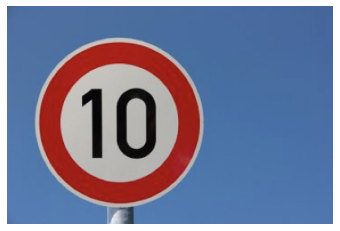

<Figure size 432x288 with 0 Axes>

In [347]:
selected_image = 102
src_image = cv.imread(f"{DATA_DIR}/road{selected_image}.png")
# src_image = cv.imread(f"data/signs/prohibitory/prohibited-action-speed.png")

fig, ax = display_bgr_image(src_image)
plt.clf();

# Image Processing
In this phase, the image will be treated in an attempt to reduce possible noise from environment and/or weather, this will be achieved by applying **CLAHE equalization** on the image, followed by an **automatic brightness and contrast correction** and finishing with the initial step of **meanShift**, this is the filtering stage of the **meanshift** segmentation that flattens color gradients and fine-grain textures of the image (see `pyrMeanShiftFiltering`).

## CLAHE Equalization

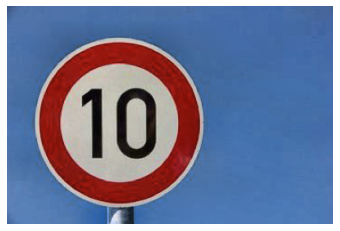

<Figure size 432x288 with 0 Axes>

In [348]:
def hsv_clahe_equalization(bgr_image, clipLimit = 2.0, tileGridSize = (8, 8)):
    hsv_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)

    h, s, v = cv.split(hsv_image)

    clahe = cv.createCLAHE(
        clipLimit=clipLimit,
        tileGridSize=tileGridSize
    )

    s_equalized = clahe.apply(s)
    v_equalized = clahe.apply(v)

    equalized_image = cv.merge([h, s_equalized, v_equalized])
    return cv.cvtColor(equalized_image, cv.COLOR_HSV2BGR)

clahe_image = hsv_clahe_equalization(src_image, clipLimit=2.0, tileGridSize=(8, 8))
fig, ax = display_bgr_image(clahe_image)
plt.clf();

## Automatic Brightness and Contrast Correction

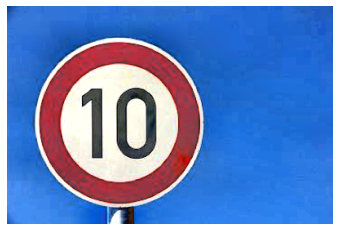

<Figure size 432x288 with 0 Axes>

In [349]:
def automatic_brightness_contrast(bgr_image, clip_hist_percent = 0.01, use_scale_abs = True, return_verbose = False):
    gray_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2GRAY)

    # Grayscale histogram of the image
    hist = cv.calcHist([gray_image], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Cumulative distribution of the histogram
    acc = []
    acc.append( float(hist[0]) )
    for i in range(1, hist_size):
        acc.append( acc[i - 1] + float(hist[i]) )
    
    # Locate points to clip
    maximum = acc[-1]
    clip_hist = clip_hist_percent * maximum / 2.0

    # Left cut
    minimum_gray = 0
    while acc[minimum_gray] < clip_hist:
        minimum_gray += 1

    # Right cut
    maximum_gray = hist_size - 1
    while acc[maximum_gray] >= (maximum - clip_hist):
        maximum_gray -= 1

    # Calculate alpha and beta values for the scaling
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = - minimum_gray * alpha

    if use_scale_abs:
        processed_image = cv.convertScaleAbs(bgr_image, alpha=alpha, beta=beta)
    else:
        processed_image = bgr_image * alpha + beta
        processed_image[processed_image < 0] = 0
        processed_image[processed_image > 255] = 255

    if return_verbose:
        processed_hist = cv.calcHist([gray_image], [0], None, [256], [minimum_gray, maximum_gray])

        return processed_image, alpha, beta, hist, processed_hist
    
    return processed_image

contrast_image = automatic_brightness_contrast(clahe_image, clip_hist_percent=0.1, use_scale_abs=True)
fig, ax = display_bgr_image(contrast_image)
plt.clf();


## Mean Shift Filtering

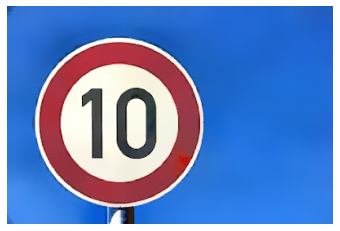

<Figure size 432x288 with 0 Axes>

In [350]:
processed_image = cv.pyrMeanShiftFiltering(contrast_image, 10, 25, 100)
fig, ax = display_bgr_image(processed_image)
plt.clf();

# Color Segmentation

In this phase, the processed image will be segmented by color. It was decided to segment the reds and blues separately. Afterwards, the segmented image is binarized by application of thresholding techniques, in this case, it was decided to use Otsu technique for thresholding. Further more, it is done a small post-processing to remove small components of the image that aren't likely to be traffic signs.

## Red Segmentation

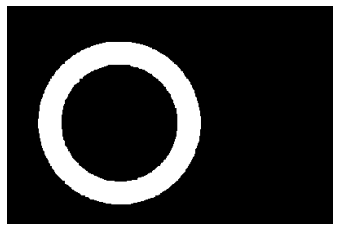

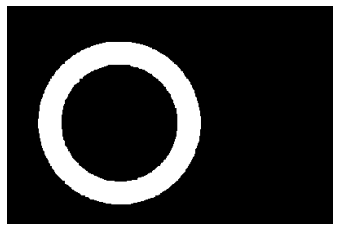

<Figure size 432x288 with 0 Axes>

In [352]:
def segment_reds(bgr_image):
    hsv_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)

    # Red zones
    lowerbound_1 = np.array([0, 40, 40])
    upperbound_1 = np.array([10, 255, 255])

    lowerbound_2 = np.array([135, 40, 40])
    upperbound_2 = np.array([180, 255, 255])

    red_1 = cv.inRange(hsv_image, lowerbound_1, upperbound_1)
    red_2 = cv.inRange(hsv_image, lowerbound_2, upperbound_2)
    mask = cv.bitwise_or(red_1, red_2)
    
    black_img = np.zeros(shape=bgr_image.shape[0:2], dtype=np.uint8)
    white_img = np.ones(shape=bgr_image.shape[0:2], dtype=np.uint8)*255
    
    gray_image = cv.bitwise_or(black_img, white_img, mask=mask)
    display_gray_image(gray_image)

    return gray_image

red_segmented_image = segment_reds(src_image)
fig, ax = display_gray_image(red_segmented_image)
plt.clf();

## Blue Segmentation

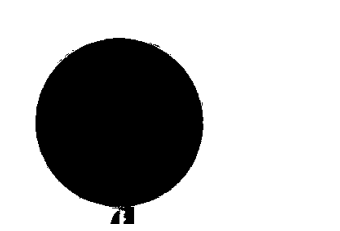

<Figure size 432x288 with 0 Axes>

In [353]:
def segment_blues(bgr_image):
    hsv_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)

    # Blue zones
    lowerbound = np.array([100, 40, 100])
    upperbound = np.array([120, 255, 255])

    mask = cv.inRange(hsv_image, lowerbound, upperbound)
    
    black_img = np.zeros(shape=bgr_image.shape[0:2], dtype=np.uint8)
    white_img = np.ones(shape=bgr_image.shape[0:2], dtype=np.uint8)*255
    
    gray_image = cv.bitwise_or(black_img, white_img, mask=mask)

    return gray_image

blue_segmented_image = segment_blues(processed_image)
fig, ax = display_gray_image(blue_segmented_image)
plt.clf();

## Post-segmentation Cleanup

TODO: rethink the `removeSmallComponents`

# RoI Extraction

In this phase, it will be extracted the regions of interest (RoI) of the segmented images, those will be considered the potential traffic signs for the next phase. To do this extraction, it will be applied an edge detector followed by extracting the contours and then the bounding rectangle of that contour as the RoI.

## Edge Detection

Edges of Red Segmented Image


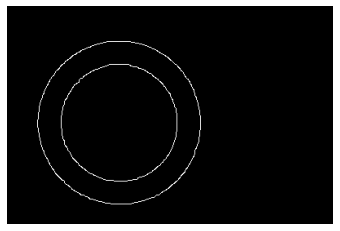

Edges of Blue Segmented Image


<Figure size 432x288 with 0 Axes>

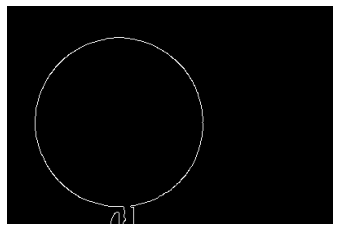

<Figure size 432x288 with 0 Axes>

In [354]:
def edge_detection(gray_image):
    # Apply morphological operation to soften possible artefacts
    kernel = np.ones(shape=(5, 5), dtype=np.uint8)
    morph_image = cv.morphologyEx(gray_image, cv.MORPH_CLOSE, kernel, iterations=1)

    return cv.Canny(morph_image, threshold1=100, threshold2=200, apertureSize=3)

red_edges = edge_detection(red_segmented_image)
print("Edges of Red Segmented Image")
fig, ax = display_gray_image(red_edges)
plt.clf();

blue_edges = edge_detection(blue_segmented_image)
print("Edges of Blue Segmented Image")
fig, ax = display_gray_image(blue_edges)
plt.clf();


## Extract RoI

Regions of interest will be bounding rectangles of the contours detected in the image processed by Canny edge detector. To eliminate redundant RoI and false positives, RoI that are contained completely inside another will be merged, and RoI which don't meet certain criteria will also be discarded.

Red Regions of Interest
14684 0


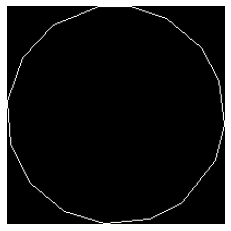

Blue Regions of Interest


<Figure size 432x288 with 0 Axes>

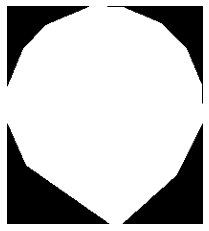

<Figure size 432x288 with 0 Axes>

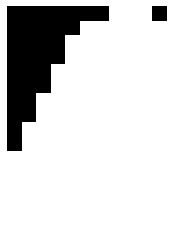

<Figure size 432x288 with 0 Axes>

In [355]:
def mergeROI(rois):
    # Sort RoI by X-coordinate and width to merge RoI
    sorted_rois = sorted(rois, key=lambda roi: (roi[0][0], -roi[0][2], roi[0][1], -roi[0][3]))

    i = 0
    while True:
        if i >= len(sorted_rois):
            break

        pivot = sorted_rois[i]
        pivot_x0, pivot_y0, pivot_x1, pivot_y1 = pivot[0][0], pivot[0][1], pivot[0][0] + pivot[0][2], pivot[0][1] + pivot[0][3]
        j = i + 1
        while True:
            if j >= len(sorted_rois):
                break

            other = sorted_rois[j]
            other_x0, other_y0, other_x1, other_y1 = other[0][0], other[0][1], other[0][0] + other[0][2], other[0][1] + other[0][3]
        
            # Beginning of other RoI is already past the ending of the pivot RoI
            if other_x0 > pivot_x1:
                break

            # Check if it's inside, and delete if so, otherwise advance
            if other_y0 > pivot_y0 and other_y1 < pivot_y1 and other_x1 < pivot_x1:
                sorted_rois.pop(j)
            else:
                j += 1
        
        i += 1
    return sorted_rois


def extractROI(edge_image, red_image, blue_image):
    contours, hierarchy = cv.findContours(edge_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # Apply convex hulls to close off shapes
    contours = [cv.convexHull(contour) for contour in contours]

    # Approximate contour
    contours = [cv.approxPolyDP(contour, 0.01 * cv.arcLength(contour, True), True) for contour in contours]

    rois = [(cv.boundingRect(contour), contour) for contour in contours]

    rois = mergeROI(rois)

    
    for i in range(len(rois)):
        (x, y, w, h), contours = rois[i]
        blue_pixels = 0
        red_pixels = 0
        for xi in range(x, x+w):
            for yi in range(y, y+h):
                if cv.pointPolygonTest(contours, (xi, yi), measureDist=False) >= 0:
                    if red_image[yi, xi] > 127:
                        red_pixels += 1
                    if blue_image[yi, xi] > 127:
                        blue_pixels += 1
        
        rois[i] = ((x, y, w, h), contours, red_pixels, blue_pixels)
    return rois

red_roi = extractROI(red_edges, red_image=red_segmented_image, blue_image=blue_segmented_image)

blue_roi = extractROI(blue_edges, red_image=red_segmented_image, blue_image=blue_segmented_image)

print("Red Regions of Interest")
for roi in red_roi:
    (x, y, w, h), contours, red_pixels, blue_pixels = roi
    region = np.zeros_like(red_edges[y:y+h, x:x+w])
    print(red_pixels, blue_pixels)
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))
    fig, ax = display_gray_image(region)
    plt.clf();

print("Blue Regions of Interest")
for roi in blue_roi:
    (x, y, w, h), contours, red_pixels, blue_pixels = roi
    region = np.zeros_like(blue_edges[y:y+h, x:x+w])
    for x0 in range(x, x+w):
        for y0 in range(y, y+h):
            if cv.pointPolygonTest(contours, (x0, y0), measureDist=False) >= 0:
                region[y0-y, x0-x] = 255
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))
    fig, ax = display_gray_image(region)
    plt.clf();
    

# Shape Detection

Shape detection for red RoI
Detected circle with probability of 0.4131791923132686. Minimum threshold was 0.325
                 circle  quadrilateral   octagon  triangle
circularity    0.330956       0.261579  0.320670  0.086796
circle_extent  0.327033       0.263781  0.324243  0.084942
extent         0.325090       0.244413  0.305173  0.125324
min_extent     0.256459       0.274481  0.260908  0.208151
AVG(P)         0.413179       0.348085  0.403665  0.168405


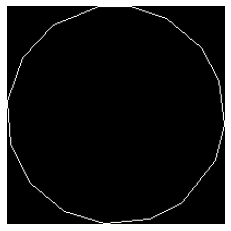

Shape detection for blue RoI
Detected octagon with probability of 0.3940780107509214. Minimum threshold was 0.325
                 circle  quadrilateral   octagon  triangle
circularity    0.325723       0.264517  0.325436  0.084324
circle_extent  0.291627       0.294812  0.307905  0.105657
extent         0.305226       0.234665  0.287807  0.172302
min_extent     0.256564       0.274880  0.261086  0.207470
AVG(P)         0.393047       0.356291  0.394078  0.189917


<Figure size 432x288 with 0 Axes>

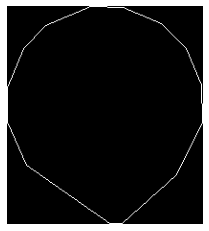

Detected quadrilateral with probability of 0.35265608837436463. Minimum threshold was 0.325
                 circle  quadrilateral   octagon  triangle
circularity    0.272784       0.313654  0.289062  0.124499
circle_extent  0.220085       0.269666  0.230145  0.280104
extent         0.285054       0.224765  0.270171  0.220009
min_extent     0.249969       0.249883  0.249948  0.250200
AVG(P)         0.342631       0.352656  0.346442  0.291604


<Figure size 432x288 with 0 Axes>

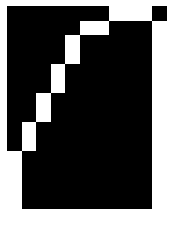

<Figure size 432x288 with 0 Axes>

In [356]:
# Mathematical ratios
circularity_ratios = {
    "circle": 1,
    "quadrilateral": 0.70,
    "octagon": 0.92,
    "triangle": 0.41,
    # "diamond": 0.64,
}

extent_ratios = {
    "circle": 0.785,
    "quadrilateral": 1,
    "octagon": 0.829,
    "triangle": 0.498,
    # "diamond": 0.5,
}

minextent_ratios = {
    "circle": 0.785,
    "quadrilateral": 1,
    "octagon": 0.829,
    "triangle": 0.498,
    # "diamond": 1
}

def detect_shape(roi, return_probabilities = False):
    (brect_x, brect_y, brect_w, brect_h), contour, red_pixels, blue_pixels = roi

    contourArea = cv.contourArea(contour)
    contourPerimeter = cv.arcLength(contour, True)
    # Bounding Rectangle Area - used to calculate extent of contour
    brect_area = brect_w * brect_h
    extent = contourArea / brect_area

    # Minimum Bounding Rectangle - takes into account orientation and fits the bounding rectangle thighly
    (min_brect_x0, min_brect_y0), (min_brect_x1, min_brect_y1), min_brect_angle = cv.minAreaRect(contour)
    min_brect_area = abs(min_brect_x0 - min_brect_x1) * abs(min_brect_y0 - min_brect_y1)

    min_extent = contourArea / min_brect_area

    # Circularity - measures how compact the contour is
    circularity = (4 * np.pi * contourArea) / (contourPerimeter * contourPerimeter + 1e-4)

    # Minimum Enclosing Circle - similar to circularity
    (min_circle_x, min_circle_y), circle_radius = cv.minEnclosingCircle(contour)
    min_circle_area = np.pi * circle_radius * circle_radius

    circle_extent = contourArea / min_circle_area

    metrics = ["circularity", "circle_extent", "extent", "min_extent"]
    ratios = [circularity, circle_extent, extent, min_extent]
    ratio_tables = [circularity_ratios, circularity_ratios, extent_ratios, minextent_ratios]
    n_metrics = len(ratios)

    classes = ["circle", "quadrilateral", "octagon", "triangle"] # Add diamond
    n_classes = len(classes)

    probability_table = np.zeros(shape=(n_metrics + 1, n_classes + 1))
    for i in range(n_metrics):
        ratio = ratios[i]
        table = ratio_tables[i]
        for j in range(n_classes):
            shape_class = classes[j]
            class_ratio = table[shape_class]
            probability_table[i, j] = abs(ratio - class_ratio) / class_ratio
        
        probability_table[i, n_classes] = np.sum(probability_table[i, 0:n_classes])
        probability_table[i, 0:n_classes] = (1 - (probability_table[i, 0:n_classes] / probability_table[i, n_classes])) / (n_classes - 1)
        probability_table[i, n_classes] = np.sum(probability_table[i, 0:n_classes])

    probability_table[n_metrics, :n_classes] = np.sum(probability_table[:-1, :-1], axis=0) / (n_classes - 1)
    probability_table[-1, n_classes] = np.sum(probability_table[-1, 0:n_classes])

    chosen_shape = ""
    max_probability = -1
    for i, shape in enumerate(classes):
        p = probability_table[-1, i] 
        if p > max_probability:
            chosen_shape = shape
            max_probability = p

    CONFIDENCE = 0.3 # Confidence threshold, how much % is needed to obtain majority
    THRESHOLD = (1 / n_classes) * (1 + CONFIDENCE)
    if max_probability < THRESHOLD:
        chosen_shape = "other"
        max_probability = -1

    if return_probabilities:
        df = pd.DataFrame(data=probability_table[:, :-1], columns=classes, index=metrics + ["AVG(P)"])
        return chosen_shape, max_probability, df, THRESHOLD

    return chosen_shape

print("Shape detection for red RoI")
for roi in red_roi:
    shape, prob, prob_table, threshold = detect_shape(roi, return_probabilities=True)

    (x, y, w, h), contours, red_pixels, blue_pixels = roi
    region = np.zeros_like(red_edges[y:y+h, x:x+w])
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))

    print(f"Detected {shape} with probability of {prob}. Minimum threshold was {threshold}")
    print(prob_table)
    fig, ax = display_gray_image(region)
    plt.clf();

print("Shape detection for blue RoI")
for roi in blue_roi:
    shape, prob, prob_table, threshold = detect_shape(roi, return_probabilities=True)

    (x, y, w, h), contours, red_pixels, blue_pixels = roi
    region = np.zeros_like(red_edges[y:y+h, x:x+w])
    cv.drawContours(region, [contours], 0, color=(255), offset=(-x, -y))

    print(f"Detected {shape} with probability of {prob}. Minimum threshold was {threshold}")
    print(prob_table)
    fig, ax = display_gray_image(region)
    plt.clf();